In [1]:
import os
import sys
import pdb
import time
import glob
import json
import functools
import multiprocessing
import numpy as np
import soundfile as sf
import scipy.interpolate
import scipy.io
import scipy.signal
import h5py
import tqdm
import soxr
import importlib
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import simulator
importlib.reload(simulator)


<module 'simulator' from '/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/simulator.py'>

In [4]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/manifest_room.pdpkl'
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/ruggles_shinncunningham_2011/manifest_room.pdpkl'
df = pd.read_pickle(fn)
df


,head_azim,head_pos_xyz,index_room,is_outdoor,room_dim_xyz,room_materials
0,0,"(3.5, 2.5, 1.8)",0,False,"(7.0, 5.0, 3.0)","(26, 26, 26, 26, 26, 26)"
1,0,"(3.5, 2.5, 1.8)",1,False,"(7.0, 5.0, 3.0)","(11, 11, 11, 11, 15, 20)"
2,0,"(3.5, 2.5, 1.8)",2,False,"(7.0, 5.0, 3.0)","(11, 11, 11, 11, 13, 17)"
3,0,"(3.5, 2.5, 1.8)",3,False,"(7.0, 5.0, 3.0)","(9, 9, 9, 9, 13, 17)"
4,0,"(3.5, 2.5, 1.8)",4,False,"(7.0, 5.0, 3.0)","(7, 7, 7, 7, 13, 17)"
5,0,"(3.5, 2.5, 1.8)",5,False,"(7.0, 5.0, 3.0)","(5, 5, 5, 5, 13, 17)"
6,0,"(3.5, 2.5, 1.8)",6,False,"(7.0, 5.0, 3.0)","(3, 3, 3, 3, 13, 17)"


In [ ]:
df_material = pd.read_csv('materials.csv')
df_material.absorption_coefficients = df_material.absorption_coefficients.map(
    lambda _: np.array(eval(_), dtype=float))
df_material.absorption_frequencies = df_material.absorption_frequencies.map(
    lambda _: np.array(eval(_), dtype=float))
dfi = df_material.iloc[-2]

simulator.get_brir(
    room_materials=[1, 2, 3] + [dfi] * 3,
    room_dim_xyz=[10, 10, 3],
    head_pos_xyz=[5, 5, 1.5],
    head_azim=0,
    src_azim=0,
    src_elev=0,
    src_dist=1.4,
    buffer=0,
    sr=44100,
    c=344.5,
    dur=0.5,
    hrtf_locs=None,
    hrtf_firs=None,
    use_hrtf_symmetry=True,
    use_log_distance=False,
    use_jitter=True,
    use_highpass=True,
    incorporate_lead_zeros=True,
    processes=8,
    strict=True,
    verbose=2)


[get_brir] loaded kemar_hrtfs (Gardner & Martin, 1994): (368, 128, 2)
[get_brir] head_pos: [5.0, 5.0, 1.5], src_pos: [6.4, 5.0, 1.5], room_dim: [10, 10, 3]
... material: brick
... material: concrete, painted
... material: window glass
... material: water surface, ie swimming pool
... material: water surface, ie swimming pool
... material: water surface, ie swimming pool
... processing 196 unique source locations
... processing 238 unique source locations
... processing 289 unique source locations
... processing 306 unique source locations
... processing 303 unique source locations


In [23]:
df_brir = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_brir.pdpkl')
df_brir = df_brir[
    (df_brir.index_room == 0) & # Facing center of speaker array room
    (df_brir.src_dist == 2) &
    (df_brir.src_azim % 10 == 0) &
    ~(np.logical_and(df_brir.src_azim > 90, df_brir.src_azim < 270)) &
    (df_brir.src_elev >= 0)
]
brir, sr_brir = util_stimuli.load_brir(
    index_room=df_brir.index_room.values[0],
    index_brir=df_brir.index_brir.values.tolist(),
    fn_pattern='/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/room{:04.0f}.hdf5',
    return_metadata=False,
    verbose=False)
df_brir['brir'] = [brir[_] for _ in range(brir.shape[0])]
df_brir['azim'] = df_brir['src_azim']
df_brir['elev'] = df_brir['src_elev']
df_brir

# print("Loading speaker array room BRIRs")
# list_data_dict = []
# for elev in [-20, -10, 0, 10, 20, 30, 40]:
#     for azim in np.arange(0, 360, 5):
#         data_dict = {
#             'azim': azim,
#             'elev': elev,
#             'brir': [],
#         }
#         for ear in ['l', 'r']:
#             basename = f'{elev}elev_{azim}az_2.47x2.60y2.00z_{ear}.wav'
#             if elev >= 0:
#                 fn = os.path.join('/om/user/francl/Room_Simulator_20181115_Rebuild/room_HRIRs/', basename)
#             else:
#                 fn = os.path.join('/om/user/francl/Room_Simulator_20181115_Rebuild/room_HRIRs/neg_elevs/', basename)
#             assert os.path.exists(fn)
#             brir, sr_src = sf.read(fn)
#             brir = soxr.resample(brir.astype(np.float32), sr_src, sr)
#             data_dict['brir'].append(brir)
#         data_dict['sr'] = sr
#         data_dict['brir'] = np.stack(data_dict['brir']).T
#         list_data_dict.append(data_dict)
# df_brir = pd.DataFrame(list_data_dict)
# df_brir_room = df_brir[np.logical_and.reduce([
#     df_brir['azim'] % 10 == 0,
#     ~(np.logical_and(df_brir['azim'] > 90, df_brir['azim'] < 270)),
#     df_brir['elev'] >= 0,
# ])].reset_index()
# print(f"Loaded speaker array room BRIRs ({len(df_brir_room)})")

# df_brir_room


,buffer,c,dur,head_azim,head_pos_xyz,incorporate_lead_zeros,index_brir,index_room,room_dim_xyz,room_materials,...,src_azim,src_dist,src_elev,use_highpass,use_hrtf_symmetry,use_jitter,use_log_distance,brir,azim,elev
506,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,506,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,0,2.0,0,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",0,0
507,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,507,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,0,2.0,10,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",0,10
508,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,508,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,0,2.0,20,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",0,20
509,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,509,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,0,2.0,30,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",0,30
510,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,510,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,0,2.0,40,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,996,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,350,2.0,0,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",350,0
997,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,997,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,350,2.0,10,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",350,10
998,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,998,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,350,2.0,20,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",350,20
999,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,999,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",...,350,2.0,30,True,True,True,False,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",350,30


In [2]:
# import generate_brir_manifest
# importlib.reload(generate_brir_manifest)

# generate_brir_manifest.mit_46_1004()


Wrote `df_room` (4 rooms / head positions):
/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_room.pdpkl
Sampling BRIR metadata for 4 rooms / head positions
Wrote `df_brir` (4032 BRIRs):
/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_brir.pdpkl


In [3]:
df = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_brir.pdpkl')
df


,buffer,c,dur,head_azim,head_pos_xyz,incorporate_lead_zeros,index_brir,index_room,room_dim_xyz,room_materials,sr,src_azim,src_dist,src_elev,use_highpass,use_hrtf_symmetry,use_jitter,use_log_distance
0,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,0,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,-20,True,True,True,False
1,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,1,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,-10,True,True,True,False
2,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,2,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,0,True,True,True,False
3,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,3,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,10,True,True,True,False
4,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,4,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,20,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,0,344.5,0.5,0,"[2.3, 2.3, 0.9]",True,1003,3,"[5.9, 4.66, 2.48]","[2, 9, 9, 9, 13, 17]",44100,355,2.0,0,True,True,True,False
4028,0,344.5,0.5,0,"[2.3, 2.3, 0.9]",True,1004,3,"[5.9, 4.66, 2.48]","[2, 9, 9, 9, 13, 17]",44100,355,2.0,10,True,True,True,False
4029,0,344.5,0.5,0,"[2.3, 2.3, 0.9]",True,1005,3,"[5.9, 4.66, 2.48]","[2, 9, 9, 9, 13, 17]",44100,355,2.0,20,True,True,True,False
4030,0,344.5,0.5,0,"[2.3, 2.3, 0.9]",True,1006,3,"[5.9, 4.66, 2.48]","[2, 9, 9, 9, 13, 17]",44100,355,2.0,30,True,True,True,False


In [5]:
# src_dist = 2.0
# src_azim = 315
# src_elev = -20
# df_tmp = df[(df.src_dist == src_dist) & (df.src_azim == src_azim) & (df.src_elev == src_elev)]
# for itr in range(len(df_tmp)):
#     kwargs = dict(df_tmp.iloc[itr])
#     kwargs['use_jitter'] = False
#     kwargs.pop('index_room')
#     kwargs.pop('index_brir')
#     print(kwargs)
#     brir = simulator.get_brir(**kwargs)
#     fig, ax = plt.subplots(figsize=(8, 2))
#     ax.plot(brir[:, 0], 'b')
#     ax.plot(brir[:, 1], 'r', lw=0.5)
#     util_figures.format_axes(
#         ax,
#         xlimits=[0, 2000])
#     plt.show()


Example audio: /om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav (shape=(132300,), sr=44100)
(1, 22050, 2) -0.01659089523980599
{'index_room': 0, 'index_brir': 966, 'sr': 44100, 'src_dist': 2.0, 'src_azim': 330.0, 'src_elev': -20.0}


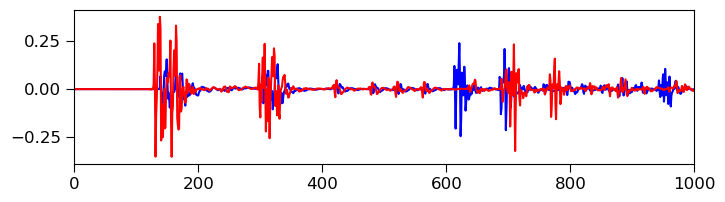

(1, 22050, 2) 0.007634904255575755
{'index_room': 1, 'index_brir': 966, 'sr': 44100, 'src_dist': 2.0, 'src_azim': 330.0, 'src_elev': -20.0}


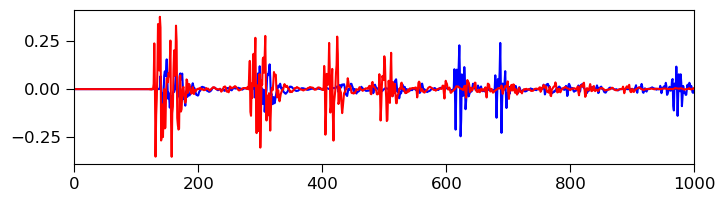

(1, 22050, 2) -0.0024792398935148813
{'index_room': 2, 'index_brir': 966, 'sr': 44100, 'src_dist': 2.0, 'src_azim': 330.0, 'src_elev': -20.0}


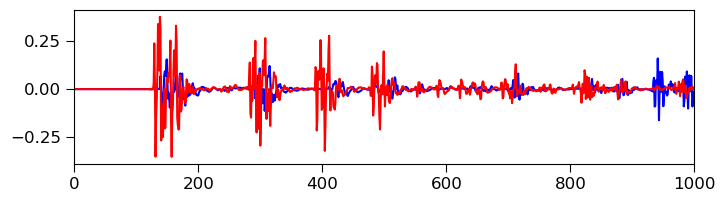

(1, 22050, 2) -0.01572644377453707
{'index_room': 3, 'index_brir': 966, 'sr': 44100, 'src_dist': 2.0, 'src_azim': 330.0, 'src_elev': -20.0}


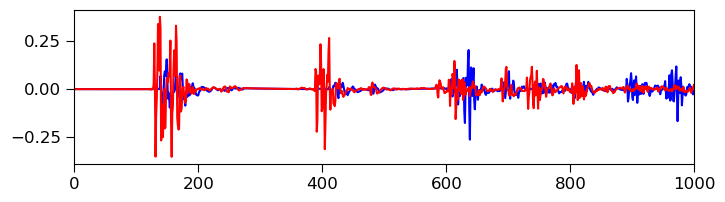

In [8]:
def load_brir(
        index_room,
        index_brir,
        fn_pattern='/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/room{:04.0f}.hdf5',
        return_metadata=False,
        verbose=False):
    """
    Load binaural room impulse response generated by `virtual_acoustic_room`.
    See `manifest_room.pdpkl` and `manifest_brir.pdpkl` for individual room,
    listener position, and BRIR specifications.
    
    For details of BRIR generation, see: https://github.mit.edu/msaddler/virtual_acoustic_room
    Room manifest: /om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/manifest_room.pdpkl
    BRIR manifest: /om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/manifest_brir.pdpkl
    
    Args
    ----
    index_room (int): index of room specifies room and listener position (hdf5 file)
    index_brir (int or list): index of source positions (dist, azim, elev) within room
    fn_pattern (str): hdf5 filename pattern (formatted with index_room) for brir dataset
    return_metadata (bool): if True, BRIR metadata dictionary is returned alongside brir
    verbose (bool): if True, BRIR metadata is printed out
    
    Returns
    -------
    brir (np.ndarray): float array with shape [len(index_brir), taps, 2]
    sr --or-- metadata (np.ndarray or dict): sampling rate in Hz or metadata dictionary
    """
    assert isinstance(index_room, (np.integer, int)), "index_room must be an int"
    assert isinstance(index_brir, (np.integer, int, list)), "index_brir must be an int or int list"
    index_brir = list(np.array(index_brir).reshape([-1]))
    with h5py.File(fn_pattern.format(index_room)) as f:
        brir = np.array([f['brir'][_] for _ in index_brir])
        sr = np.array([f['sr'][_] for _ in index_brir])
        if return_metadata or verbose:
            metadata = {}
            for k in ['index_room', 'index_brir', 'sr', 'src_dist', 'src_azim', 'src_elev']:
                metadata[k] = np.array([f[k][_] for _ in index_brir])
            if verbose:
                print(fn_pattern.format(index_room))
                for k in metadata.keys():
                    print(f'|__ {k}: {metadata[k]}')
    if return_metadata:
        return brir, metadata
    return brir, sr



fn_audio = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr = sf.read(fn_audio)
# # Replace example audio clip with noise bursts
# y = np.random.randn(*y.shape)
# t = np.arange(0, len(y)) / sr
# y = (np.sin(2 * np.pi * 2 * t) > 0) * y
# fn_audio = 'WHITE NOISE BURSTS'
print(f'Example audio: {fn_audio} (shape={y.shape}, sr={sr})')
# ipd.display(ipd.Audio(rate=sr, data=y))


src_dist = 2.0
src_azim = 330
src_elev = -20
index_brir = df[(df.src_dist == src_dist) & (df.src_azim == src_azim) & (df.src_elev == src_elev)].index_brir.unique()[0]
for index_room in range(4):
    brir, metadata = load_brir(
        index_room=index_room,
        index_brir=index_brir,
        fn_pattern='/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/room{:04.0f}.hdf5',
        return_metadata=True,
        verbose=False)
    print(brir.shape, brir.sum())
    
    for _, itr_brir in enumerate(range(brir.shape[0])):
        print({k: v[_] for k, v in metadata.items()})
        y_spatialized = util_stimuli.spatialize_sound(y, brir[itr_brir])
        ipd.display(ipd.Audio(rate=sr, data=y_spatialized.T, normalize=True))

        fig, ax = plt.subplots(figsize=(8, 2))
        ax.plot(brir[itr_brir, :, 0], 'b')
        ax.plot(brir[itr_brir, :, 1], 'r')
        util_figures.format_axes(
            ax,
            xlimits=[0, 1000])
        plt.show()


In [29]:
# fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/manifest_brir.pdpkl'
# df = pd.read_pickle(fn)

# df = df[df.index_room == 0]
# df = df.groupby(['src_azim', 'src_elev']).agg({'index_brir': list}).reset_index()
# map_loc_to_index_brir = {}
# for key, val in zip(zip(df.src_azim, df.src_elev), df.index_brir):
#     map_loc_to_index_brir[key] = val
# map_loc_to_index_brir


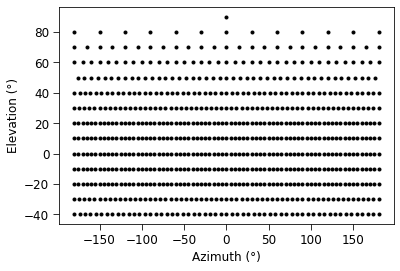

In [9]:
hrtf_locs, hrtf_firs, hrtf_sr = simulator.load_kemar_hrtfs(npz_filename='kemar_hrtfs/hrtfs.npz')

IDX_nonzero_azim = hrtf_locs[:, 1] != 0
opposite_hrtf_locs = hrtf_locs[IDX_nonzero_azim, :]
opposite_hrtf_locs[:, 1] = -1 * opposite_hrtf_locs[:, 1] # Multiply azimuth by negative one
opposite_hrtf_firs = np.flip(hrtf_firs[IDX_nonzero_azim, :, :], axis=2) # Switch left/right channel
hrtf_locs = np.concatenate([opposite_hrtf_locs, hrtf_locs], axis=0)
hrtf_firs = np.concatenate([opposite_hrtf_firs, hrtf_firs], axis=0)
hrtf_locs.shape, hrtf_firs.shape

"""
Check kemar_hrtf locations (azimuths and elevations)
"""
fig, ax = plt.subplots()
x = hrtf_locs[:, 1]
y = hrtf_locs[:, 2]
ax.plot(x, y, 'k.')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Azimuth (°)',
    str_ylabel='Elevation (°)')
plt.show()


In [ ]:
"""
Run this cell to start the MATLAB engine for Python and import `simulator_matlab`
"""
import matlab.engine
import simulator_matlab
importlib.reload(simulator_matlab)

eng = matlab.engine.start_matlab();
if 'src/' not in eng.path():
    eng.addpath('src/');


In [ ]:
"""
Quit MATLAB engine
"""
eng.quit()


In [ ]:
"""
DEBUGGING: CLOSELY COMPARE MATLAB AND PYTHON SIMULATORS UNDER DIFFERENT CONDITIONS

NOTES:
- Resulting BRIRs are sometimes offset by one or two samples
    - May be due to an off-by-one indexing error when porting MATLAB to Python
    - May be due to numerical precision differences
"""
room_materials = [26]*6#[1, 1, 1, 1, 15, 16]
room_dim_xyz = [7, 8, 4]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = -49
src_azim = 145
src_elev = 20
src_dist = 3.4
buffer = 0.5

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
incorporate_lead_zeros = True
use_log_distance = True
hrtf_locs = None
hrtf_firs = None

importlib.reload(simulator)

np.random.seed(0)
brir_python = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    hrtf_locs=hrtf_locs,
    hrtf_firs=hrtf_firs,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    processes=8,
    strict=True,
    verbose=2)


In [ ]:
importlib.reload(simulator_matlab)

np.random.seed(0)
brir_matlab = simulator_matlab.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    eng=eng)


In [ ]:
fig, ax_arr = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)

offset_brir_python = brir_python[1:]
offset_brir_matlab = brir_matlab[:-1]

ax_arr[0].plot(offset_brir_python[:, 0], 'b')
ax_arr[0].plot(offset_brir_python[:, 1], 'r')
ax_arr[0].plot(offset_brir_matlab[:, 0], 'c', ls=':')
ax_arr[0].plot(offset_brir_matlab[:, 1], 'm', ls=':')
ax_arr[1].plot(offset_brir_python[:, 0] - offset_brir_matlab[:, 0], 'b')
ax_arr[1].plot(offset_brir_python[:, 1] - offset_brir_matlab[:, 1], 'r')

for ax in ax_arr:
    util_figures.format_axes(
        ax,
        xlimits=[0, 500],
#         ylimits=[-0.01, 0.01]
    )
plt.show()


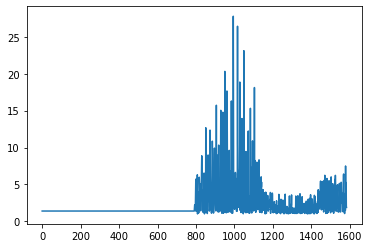

AZIM:70.0, ELEV:0.0, DIST:20.315961431695275


In [105]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/room0008.hdf5'
with h5py.File(fn, 'r') as f:
    list_brir = f['brir'][:]
    list_src_dist = f['src_dist'][:]
    list_src_azim = f['src_azim'][:]
    list_src_elev = f['src_elev'][:]
    sr = f['sr'][0]

fig, ax = plt.subplots()
ax.plot(list_src_dist)
# ax.plot(list_src_azim)
# ax.plot(list_src_elev)
plt.show()

idx = np.random.randint(800, 1100)
brir = list_brir[idx]
azim = list_src_azim[idx]
elev = list_src_elev[idx]
dist = list_src_dist[idx]

print(f"AZIM:{azim}, ELEV:{elev}, DIST:{dist}")


In [106]:
fn_audio = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr_audio = sf.read(fn_audio)

# Replace example audio clip with noise bursts
y = np.random.randn(*y.shape)
t = np.arange(0, len(y)) / sr_audio
y = (np.sin(2 * np.pi * 2 * t) > 0) * y
fn_audio = 'WHITE NOISE BURSTS'

print(f'Example audio: {fn_audio} (shape={y.shape}, sr={sr_audio})')
# ipd.display(ipd.Audio(rate=sr_audio, data=y))

y_spatialized = util_stimuli.spatialize_sound(y, brir)
ipd.display(ipd.Audio(rate=sr, data=y_spatialized.T, normalize=True))


Example audio: WHITE NOISE BURSTS (shape=(132300,), sr=44100)


In [107]:
fn_manifest_brir = "/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/manifest_brir.pdpkl"
index_room = 8
df_manifest_brir = pd.read_pickle(fn_manifest_brir)
df = df_manifest_brir[df_manifest_brir.index_room == index_room]
df


,buffer,c,dur,head_azim,head_pos_xyz,incorporate_lead_zeros,index_brir,index_room,room_dim_xyz,room_materials,sr,src_azim,src_dist,src_elev,use_highpass,use_hrtf_symmetry,use_jitter,use_log_distance
12672,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,0,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-40,True,True,True,False
12673,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-30,True,True,True,False
12674,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,2,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-20,True,True,True,False
12675,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,3,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-10,True,True,True,False
12676,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,4,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,0,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14251,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1579,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,3.571293,20,True,True,True,False
14252,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1580,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,4.581923,30,True,True,True,False
14253,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1581,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,5.253641,40,True,True,True,False
14254,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1582,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,2.046637,50,True,True,True,False


In [22]:
import generate_brir_manifest
importlib.reload(generate_brir_manifest)

for _ in range(100):
    np.random.seed(_)
    room_parameters = generate_brir_manifest.sample_room_parameters(
        verbose=False)
    head_parameters = generate_brir_manifest.sample_head_parameters(
        room_dim_xyz=room_parameters['room_dim_xyz'],
        verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_azim = 0
    head_pos_xyz = head_parameters['head_pos_xyz']
    buffer = 0
    for src_azim in range(0, 360, 15):
        for src_elev in range(-60, 61, 5):
            src_dist = generate_brir_manifest.distance_to_wall(
                room_dim_xyz,
                head_pos_xyz,
                head_azim,
                src_azim,
                src_elev)
            src_pos_xyz = np.array([
                src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
                src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
                src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
            ])
            assert simulator.is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer), "Invalid head position"
            if (np.sum(np.isclose(src_pos_xyz, 0)) == 1) or (np.sum(np.isclose(src_pos_xyz, room_dim_xyz)) == 1):
                pass
            else:
                print(src_azim, src_elev, room_dim_xyz, src_pos_xyz)


/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/generate_brir_manifest.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  ry = (room_dim_xyz[1] - head_pos_xyz[1]) / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))


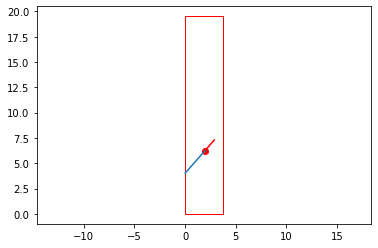

Checked src_azim: -180 = 180.0


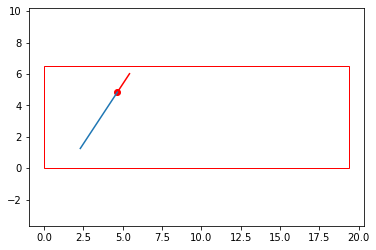

Checked src_azim: -180 = 180.0


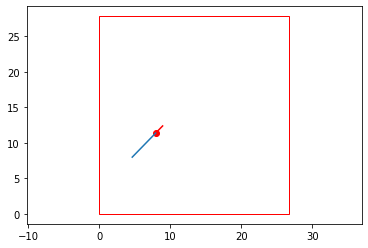

Checked src_azim: -180 = 180.0


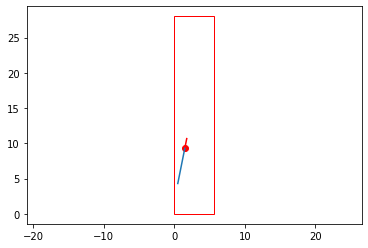

Checked src_azim: -180 = 179.99999914622634


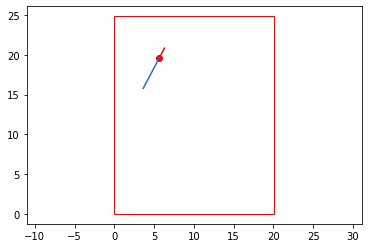

Checked src_azim: -180 = 179.99999914622634


In [23]:
import generate_brir_manifest
importlib.reload(generate_brir_manifest)

for _ in range(5):
    room_parameters = generate_brir_manifest.sample_room_parameters(verbose=False)
    head_parameters = generate_brir_manifest.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_pos_xyz = head_parameters['head_pos_xyz']
    
    fig, ax = plt.subplots()
    rect = matplotlib.patches.Rectangle((0, 0), room_dim_xyz[0], room_dim_xyz[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.plot(head_pos_xyz[0], head_pos_xyz[1], 'ro')
    src_azim = -180
    src_elev = 20
    src_dist = generate_brir_manifest.distance_to_wall(
        room_dim_xyz,
        head_pos_xyz,
        head_azim=head_azim,
        src_azim=src_azim,
        src_elev=src_elev)
    dhx = 1.4 * np.cos(np.deg2rad(head_azim))
    dhy = 1.4 * np.sin(np.deg2rad(head_azim))
    dx = src_dist * np.cos(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    dy = src_dist * np.sin(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dhx], [head_pos_xyz[1], head_pos_xyz[1] + dhy], 'r-')
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dx], [head_pos_xyz[1], head_pos_xyz[1] + dy])
    ax.set_aspect('equal', 'datalim')
    plt.show()
    
    vector1 = np.array([dx, dy])
    vector2 = np.array([dhx, dhy])
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.rad2deg(np.arccos(dot_product))
    print(f'Checked src_azim: {src_azim} = {angle}')
